<a href="https://colab.research.google.com/github/AvantiShri/oceanography_colab_notebooks/blob/master/for_rian/ConstrainedWaterMassAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cvxpy as cp

In [2]:
!pip install gsw

In [3]:
import gsw

In [4]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv

--2020-10-19 07:57:40--  https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ
Resolving docs.google.com (docs.google.com)... 173.194.217.100, 173.194.217.113, 173.194.217.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.217.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cr92brr4fc9gtuonp02vmm2fepa4qc5s/1603094250000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download [following]
--2020-10-19 07:57:41--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cr92brr4fc9gtuonp02vmm2fepa4qc5s/1603094250000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 74.125.31.132, 2607:f8b0:400c:c02::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s-a

In [5]:
def augment_df_with_PO_NO_SiO(df):  
  #remineralization ratios
  r_PO = 155;
  r_SiO = 15
  r_NO = 9.68
  df["PO"] = df["oxygen"] + df["phosphate"]*r_PO
  df["NO"] = df["oxygen"] + df["nitrate"]*r_NO
  df["SiO"] = df["oxygen"] + df["silicate"]*r_SiO

In [6]:
import pandas as pd
import numpy as np

header = ["c"+str(i) for i in range(1,30)]
header[4] = "bottle flag"
header[16] = "bottle salinity flag"
header[20] = "bottle oxygen flag"
header[22] = "silicate flag"
header[24] = "nitrate flag"
header[28] = "phosphate flag"

header[11] = "CTD pressure"
header[12] = "CTD temperature"
header[15] = "practical_salinity" #practical salinity
header[8] = "latitude"
header[9] = "longitude"

header[0] = "stnnbr"
header[5] = "geotrc_ID"
header[10] = "bottom depth"
header[19] = "oxygen"
header[21] = "silicate"
header[23] = "nitrate"
header[27] = "phosphate"

gp15_df = pd.read_csv("names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv",
                      names=header, na_values = -999)

#remove bad data
for flag_type in ["bottle flag", "bottle salinity flag", "bottle oxygen flag",
              "silicate flag", "nitrate flag", "phosphate flag"]:
    gp15_df = gp15_df[gp15_df[flag_type] <= 2]
gp15_df = pd.DataFrame(gp15_df)

augment_df_with_PO_NO_SiO(gp15_df)

absolute_salinity = gsw.SA_from_SP(SP=gp15_df["practical_salinity"],
                                   p=gp15_df["CTD pressure"],
                                   lon=gp15_df["longitude"],
                                   lat=gp15_df["latitude"])
gp15_df["absolute_salinity"] = absolute_salinity

conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                  t=gp15_df["CTD temperature"],
                                  p=gp15_df["CTD pressure"])
gp15_df["conservative_temp"] = conservative_temp

potential_temp = gsw.pt_from_CT(SA=absolute_salinity,
                                CT=conservative_temp)
gp15_df["potential_temp"] = potential_temp

sig0 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000
gp15_df["sig0"] = sig0
sig1500 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=1500) - 1000
sig2000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=2000) - 1000
sig3000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=3000) - 1000
sig4000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=4000) - 1000

z = gsw.z_from_p(p=gp15_df["CTD pressure"], lat=gp15_df["latitude"])
depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
gp15_df["depth"] = depth

spic0 = gsw.spiciness0(SA=absolute_salinity, CT=conservative_temp)
gp15_df["spiciness"] = spic0

#calculation of planetary vorticity
rho_ref = 1000.0 #reference density
Omega = 2*np.pi/86400;
f = np.mean(2*Omega*np.sin(gp15_df["latitude"]*(np.pi/180.0)))
PV = -(f/rho_ref)*(np.gradient(sig0, depth))
gp15_df["PV"] = PV #potential vorticity

print("Rows:",len(gp15_df))
gp15_df = gp15_df.dropna()
print("Rows without NA values:",len(gp15_df))

gp15_df["mass"] = 1

Rows: 940
Rows without NA values: 926


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1061: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1062: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1063: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1069: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [7]:

def prepare_water_mass_df(water_mass_arr):
    df = pd.DataFrame(data=water_mass_arr,
                      columns=["watermassname",
                               "potential_temp", "practical_salinity",
                               "oxygen", "phosphate", "silicate",
                               "nitrate", "spiciness", "PV"])
    augment_df_with_PO_NO_SiO(df)
    df["mass"] = 1
    return df

                             #Temp  Sal     Oxy     Phos   Sili   Nitr    Spic      Vort
P16_Emilie_AAIW = ["AAIW",    5.68, 34.307, 237.0,  1.77,  16.60, 25.5,   0.068,    88.86E-12]
PSUW =            ["PSUW",    4.03, 33.38,	174.7,	2.35,  59.34, 31.24,  -0.964,  970.78E-12]
GLODAP_ESSW =     ["ESSW",   12.2,  34.86,  84.6,   1.87,  21.58, 25.87,   1.419,    2.66E-12]
GLODAP_mystery =  ["Mystery", 2.09, 34.53,   36.1,  3.03, 168.87, 43.5,  -0.154,    26.95E-12]
GLODAP_EqPIW =    ["EqPIW",   7.65, 34.60,   48.50, 2.71,  44.53, 38.26,  0.568,     0.01E-12]
GLODAP_NPIW =     ["NPIW",    4.72, 34,      81.8,  2.64,  79.87, 36.48, -0.262,   130.26E-12]
PDW1 =            ["PDW1",    1.78, 34.59,   59.60, 2.92, 166.62, 41.38, -0.140,    19.14E-12]
P16_UCDW =        ["UCDW",    2.6,  34.575, 168,    2.4,   85.7,  34.4,  -0.1,      37.49E-12]
PDW23 =           ["PDW23",   1.23, 34.67,  128.50, 2.62, 164.89, 37.24, -0.182,     6.05E-12]
P16_LCDW =        ["LCDW",    1.62, 34.738, 195,    2.17,  96.6,  31,    -0.066,    12.55E-12]
GLODAP_AABW =     ["AABW",    0.18, 34.70,  219,    2.27, 124.45, 32.57, -0.203,     2.90E-12]


In [8]:
from collections import OrderedDict


import scipy
import scipy.spatial


def spherical_to_surface_cartesian(lat, lon):
    r = 6.371*(1E3) #earth radius
    theta = ((1-lat)/180.0)*np.pi
    phi = (lon/180.0)*np.pi
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    return (x,y)


def add_surface_cartesian_coordinates_to_df(df):
    latitudes = df["latitude"]
    longitudes = df["longitude"]
    xs,ys = list(zip(*[spherical_to_surface_cartesian(*x)
                       for x in zip(latitudes, longitudes)]))
    df["x"] = xs
    df["y"] = ys
    #plt.scatter(xs, ys)
    #plt.show()


def compute_pairwise_distances_depthmetric(df, depth_metric, depth_scale):
    xs = df["x"]
    ys = df["y"]
    
    depth_metric = np.array(df[depth_metric])
    depth_diffs = np.abs(depth_metric[:,None] -
                         depth_metric[None,:])*depth_scale

    #plt.hist(depth_diffs.ravel(), bins=20)
    #plt.show()

    coors = np.array([xs, ys]).transpose((1,0))
    euclidean_distances = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(coors))
    #plt.hist(euclidean_distances.ravel(), bins=100)
    #plt.show()

    weighted_distances = np.sqrt(np.square(euclidean_distances)
                                 + np.square(depth_diffs))
    #plt.hist(weighted_distances.ravel(), bins=20)
    #plt.show()
    return weighted_distances


def make_pairs_matrix(obs_df, depth_metric, depth_scale, nneighb):
    obs_df = pd.DataFrame(obs_df)
    add_surface_cartesian_coordinates_to_df(obs_df)
    pairwise_distances = compute_pairwise_distances_depthmetric(
        obs_df, depth_metric=depth_metric, depth_scale=depth_scale)
    #plt.hist(pairwise_distances.ravel(), bins=20)
    #plt.show()
    nneighb_thresh = np.sort(pairwise_distances, axis=-1)[:,nneighb]
    masked_pairwise_distances =\
      (pairwise_distances*(pairwise_distances <= nneighb_thresh[:,None])
                         *(pairwise_distances > 0))
    pairs_to_consider_indices = np.nonzero(masked_pairwise_distances)
    print("Constrained pairs:",len(pairs_to_consider_indices[0]))
    pairs_distances = pairwise_distances[
        pairs_to_consider_indices[0],
        pairs_to_consider_indices[1]]
    #plt.hist(pairs_distances.ravel(), bins=20)
    #plt.show()
    pairs_matrix = np.zeros((len(pairs_to_consider_indices[0]),
                              len(obs_df)))
    pairs_matrix[np.arange(len(pairs_distances)),
                  pairs_to_consider_indices[0]] = 1.0/nneighb#(
                      #1/pairs_distances)
    pairs_matrix[np.arange(len(pairs_distances)),
                  pairs_to_consider_indices[1]] = -1.0/nneighb#(
                      #1/pairs_distances)
    return pairs_matrix


class OMPAProblem(object):

    def __init__(self, watermass_df, obs_df, paramsandweighting,
                       smoothness_lambda):
        self.watermass_df = watermass_df
        self.obs_df = obs_df
        self.paramsandweighting = paramsandweighting
        #split up the paramsandweighting into params and weighting
        self.params_to_use, self.weighting = [list(x) for x in 
                                              zip(*paramsandweighting)]
        self.smoothness_lambda = smoothness_lambda

    def core_solve(self, A, b, pairs_matrix, verbose=True):
        #We are going to solve the following problem:
        # Minimize (x A - b)^2
        # Subject to x >= 0, cp.sum(x, axis=1) == 1
        # x has dimensions of observations X end_members
        # A has dimensions of end_members X parameteres
        # b has dimensions of observations X parameters
       
        x = cp.Variable(shape=(len(b), len(A)))
        obj = cp.sum_squares(x@A - b)
        if (self.smoothness_lambda is not None):
            obj += self.smoothness_lambda*cp.sum_squares(pairs_matrix@x)
        obj = cp.Minimize(obj)
        
        constraints = [x >= 0, cp.sum(x,axis=1)==1]
        prob = cp.Problem(obj, constraints)
        prob.solve(verbose=True, max_iter=20000)
        
        print("status:", prob.status)
        print("optimal value", prob.value)

        water_mass_fractions = x.value
        residuals_squared = np.sum(
            np.square((water_mass_fractions@A) - b), axis=-1)
        
        return water_mass_fractions, residuals_squared

    def solve(self):

        watermass_df = self.watermass_df
        obs_df = pd.DataFrame(self.obs_df)
        params_to_use = self.params_to_use
        weighting = np.array(self.weighting)
            
        A = np.array(watermass_df[params_to_use])
        b = np.array(obs_df[params_to_use])
        
        print("params to use:", params_to_use)
        print("param weighting:", weighting)
        A = A*weighting[None,:]
        b = b*weighting[None,:]

        pairs_matrix = make_pairs_matrix(
            obs_df=obs_df,
            depth_metric="depth",
            depth_scale=1.0,
            nneighb=4)

        water_mass_fractions, residuals_squared = self.core_solve(
            A=A, b=b, pairs_matrix=pairs_matrix)      
        print("objective:", np.sum(residuals_squared))

        param_reconstruction = (water_mass_fractions@A)/weighting[None,:]
        param_residuals = b/weighting[None,:] - param_reconstruction

        self.water_mass_fractions = water_mass_fractions
        self.param_reconstruction = param_reconstruction
        self.param_residuals = param_residuals


gp15_intermediate = gp15_df[(gp15_df["sig0"] >= 26.6)
                            & (gp15_df["sig0"] <= 27.72)]

intermediate_paramsandweighting = [("potential_temp",140),
                                   ("practical_salinity",100),
                                   ("silicate",30),
                                   ("NO",10),
                                   #("PO",10),
                                   ("spiciness",10),
                                   #("PV",10),
                                   ]

watermassdfname_to_dfs = OrderedDict()  
watermassdfname_to_dfs['intermediate'] =\
  (prepare_water_mass_df([P16_Emilie_AAIW,
                          PSUW,
                          GLODAP_ESSW,
                          GLODAP_NPIW,
                          PDW1,
                          P16_UCDW,
                          PDW23
                          ]),
   gp15_intermediate)


ompa_setting_to_soln = OrderedDict()
for watermassdfname, (watermass_df, obs_df) in watermassdfname_to_dfs.items():
    for (weightingname, weighting) in [("weighting1", intermediate_paramsandweighting)]:
        for smoothness_lambda in [0, 10000, 100000, 1000000]:
            print(watermassdfname, weightingname)
            ompa_problem = OMPAProblem(
              watermass_df = watermass_df,
              obs_df = obs_df,
              paramsandweighting=weighting,
              smoothness_lambda=smoothness_lambda)
            ompa_problem.solve()
            ompa_setting_to_soln[(watermassdfname,
                                  smoothness_lambda,
                                  weightingname)] = ompa_problem


intermediate weighting1
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO', 'spiciness']
param weighting: [140 100  30  10  10]
Constrained pairs: 1656
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 16560, constraints m = 16974
          nnz(P) + nnz(A) = 59202
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 20000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho    

Plottin water mass fractions
Setting: ('intermediate', 0, 'weighting1')


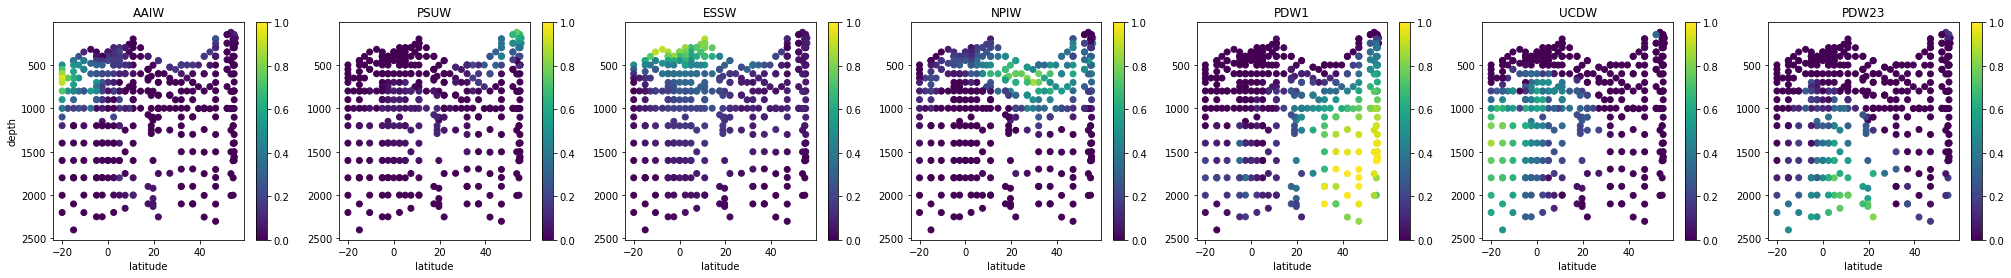

Setting: ('intermediate', 10000, 'weighting1')


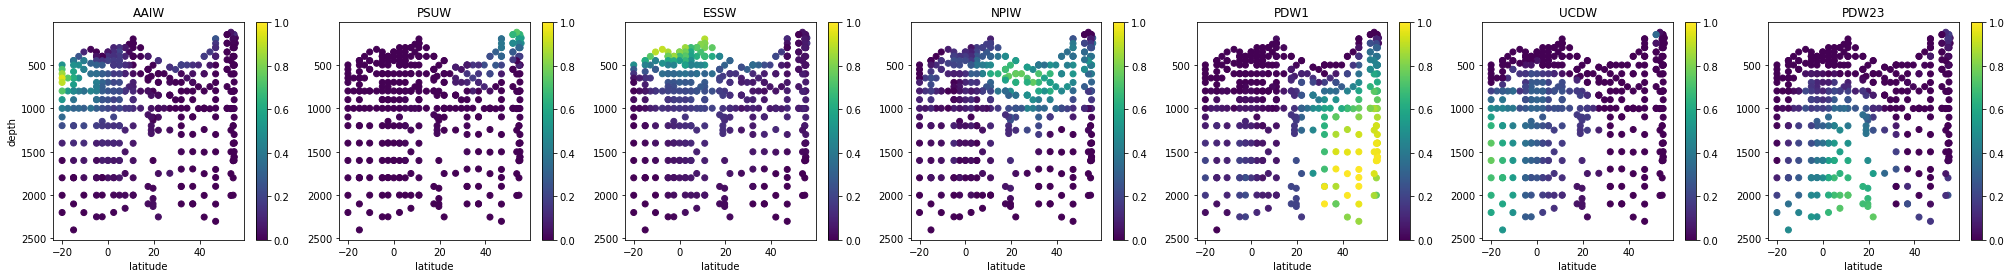

Setting: ('intermediate', 100000, 'weighting1')


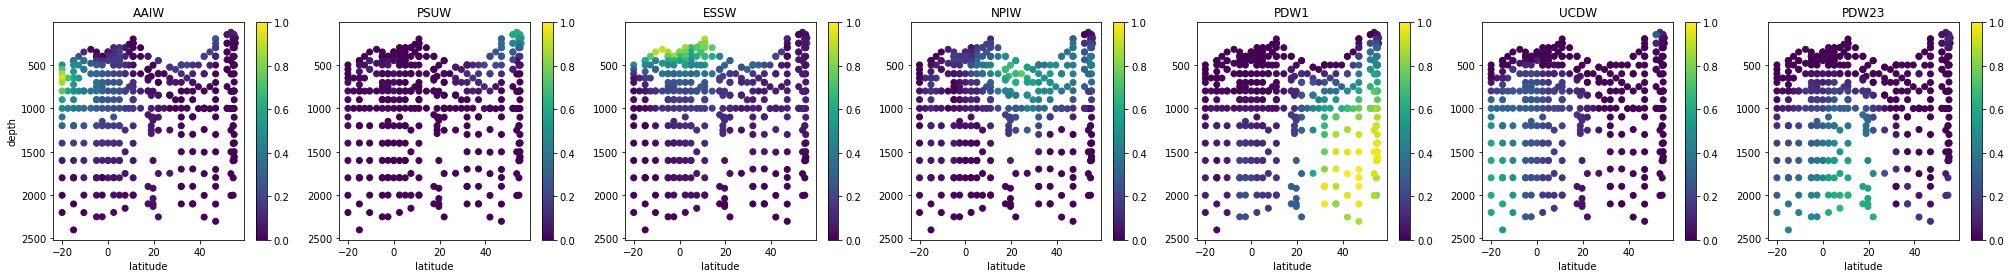

Setting: ('intermediate', 1000000, 'weighting1')


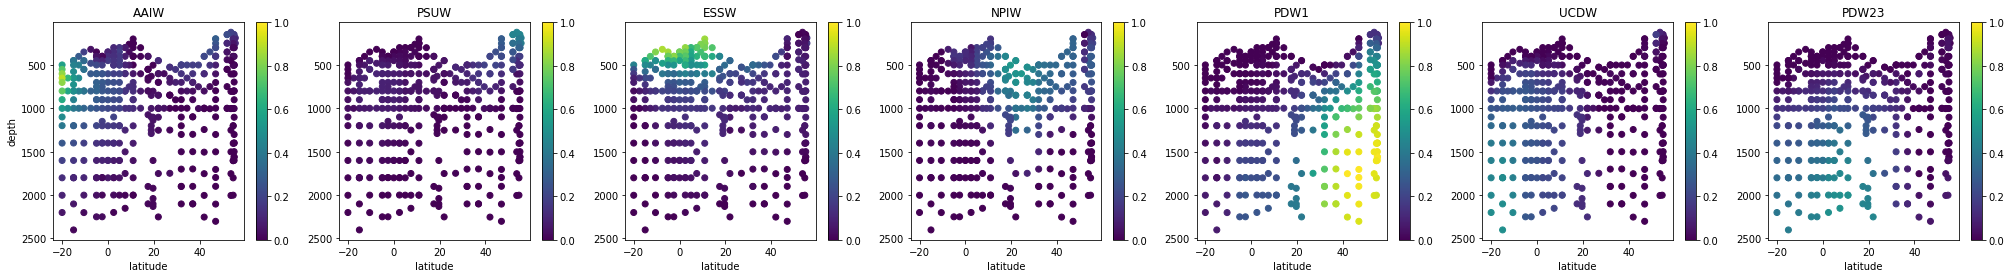

Plotting absolute residuals
Setting: ('intermediate', 0, 'weighting1')


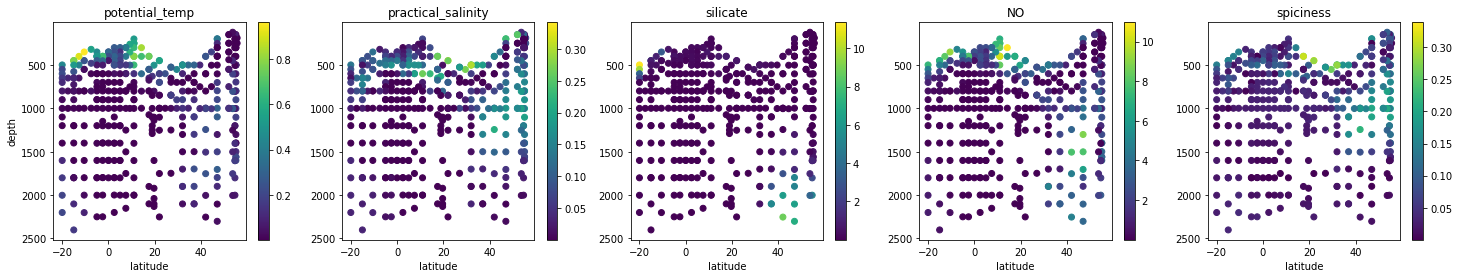

Setting: ('intermediate', 10000, 'weighting1')


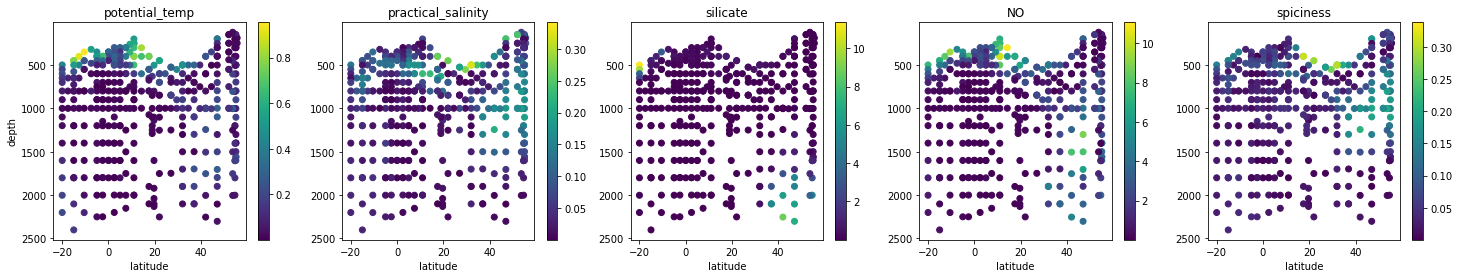

Setting: ('intermediate', 100000, 'weighting1')


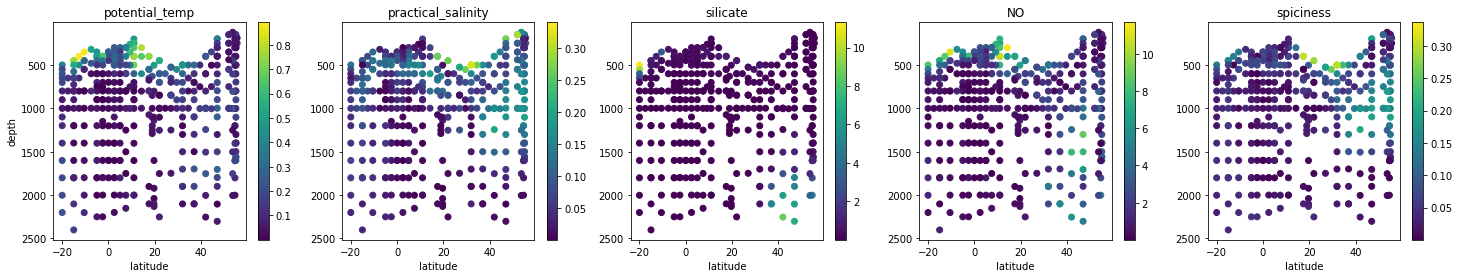

Setting: ('intermediate', 1000000, 'weighting1')


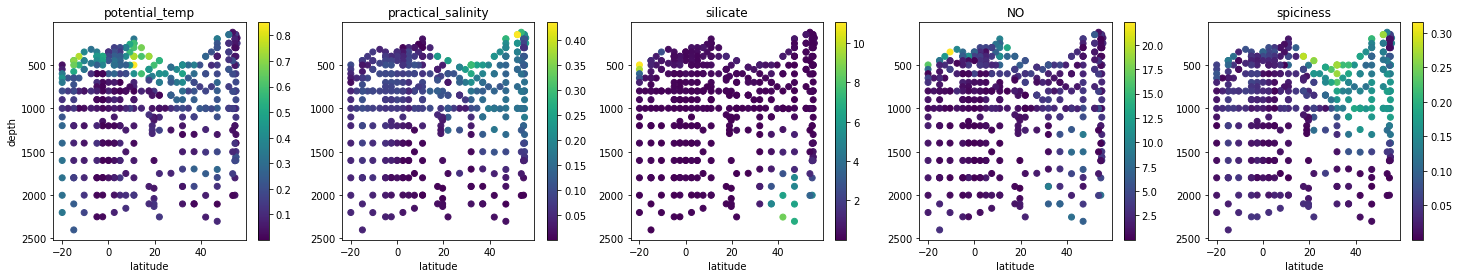

In [9]:
from matplotlib import pyplot as plt


def plot_water_mass_fractions(ompa_problem, yaxis="depth"):
    num_watermasses = ompa_problem.water_mass_fractions.shape[1]
    fig, ax = plt.subplots(nrows=1, ncols=num_watermasses,
                           figsize=(5*num_watermasses,4))
    for i in range(num_watermasses):
        plt.sca(ax[i])
        plt.scatter(ompa_problem.obs_df["latitude"],
                    ompa_problem.obs_df[yaxis],
                    c=ompa_problem.water_mass_fractions[:,i])
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.colorbar()
        plt.clim(0,1)
        plt.title(ompa_problem.watermass_df["watermassname"][i])
    plt.show()


def plot_residuals(ompa_problem):
    num_params = ompa_problem.param_residuals.shape[1]
    fig, ax = plt.subplots(nrows=1, ncols=num_params,
                           figsize=(5*num_params,4))
    for i in range(ompa_problem.param_residuals.shape[1]):
        plt.sca(ax[i])
        plt.scatter(x=ompa_problem.obs_df["latitude"],
                    y=ompa_problem.obs_df["depth"],
                    c=np.abs(ompa_problem.param_residuals[:,i]),
                    cmap="viridis")
        plt.colorbar()
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.title(ompa_problem.params_to_use[i])
    plt.show()


print("Plottin water mass fractions")
for setting in ompa_setting_to_soln:
    print("Setting:", setting)
    plot_water_mass_fractions(ompa_setting_to_soln[setting])

print("Plotting absolute residuals")
for setting in ompa_setting_to_soln:
    print("Setting:", setting)
    plot_residuals(ompa_setting_to_soln[setting])  

In [10]:
import altair as alt
#Build an interactive visualization

CHART_WIDTH=200
CHART_HEIGHT=200
FONTSIZE=10
ROWSIZE=7

def nozero_xaxis(field_name):
  return alt.X(field_name, scale=alt.Scale(zero=False))


def nozero_yaxis(field_name, domain=None):
  if (domain is None):
    return alt.Y(field_name, scale=alt.Scale(zero=False))
  else:
    return alt.Y(field_name, scale=alt.Scale(zero=False, domain=domain))


def latdepth_scatterplot(basechart, selection,
                         property_name, altairdf, zerocenter=False):
    additional_color_kwargs = {}
    if (zerocenter):
        max_abs_property = np.max(np.abs(altairdf[property_name]))
        scale = alt.Scale(scheme='blueorange',
                          domain=[max_abs_property, -max_abs_property])
        additional_color_kwargs['scale'] = scale
    color = alt.condition(selection, property_name, alt.value('lightgray'),
                          title="",
                          **additional_color_kwargs)
    max_depth = np.max(altairdf["depth"])*1.05
    to_return = basechart.encode(
              nozero_xaxis("latitude"),
              nozero_yaxis("depth", domain=(max_depth,0))
           ).encode(color=color).properties(title=property_name)
    return to_return
           

def wrap_scatterplots(scatterplots, resolve_scale='shared'):
    hconcats = [
        alt.hconcat(*scatterplots[i:i+ROWSIZE]).resolve_scale(
            color=resolve_scale)
        for i in range(0,len(scatterplots), ROWSIZE)  
    ]
    return alt.vconcat(*hconcats)


def pp_scatterplot(obs_basechart, watermass_basechart,
                   property1, property2):
    return (obs_basechart.mark_point(opacity=0.2).encode(nozero_xaxis(property1),
                                 nozero_yaxis(property2))
            + watermass_basechart.encode(nozero_xaxis(property1),
                                         nozero_yaxis(property2)))


def build_altair_viz(ompa_problem):
    altairdf = pd.DataFrame(ompa_problem.obs_df)
    watermass_names = []
    for water_mass_idx in range(ompa_problem.water_mass_fractions.shape[1]):
      watermass_name =\
        ompa_problem.watermass_df["watermassname"][water_mass_idx]
      watermass_names.append(watermass_name)
      altairdf[watermass_name] =\
          ompa_problem.water_mass_fractions[:,water_mass_idx]

    for param_idx in range(ompa_problem.param_residuals.shape[1]):
        param_name = ompa_problem.params_to_use[param_idx]
        altairdf[param_name+"_resid"] =\
          ompa_problem.param_residuals[:,param_idx]

    interval_selection = alt.selection_interval()
    tooltip_columns = (ompa_problem.params_to_use
                       + ["latitude", "longitude"]
                       + watermass_names
                       + [x+"_resid" for x in ompa_problem.params_to_use])
    #make the linked property-property plots
    obs_basechart = alt.Chart(altairdf).mark_point().encode(
      tooltip=tooltip_columns,
      color=alt.condition(interval_selection,
                          alt.value("lightblue"),#"NPIW",
                          alt.value('lightgray'))
      ).add_selection(interval_selection).properties(
          width=CHART_WIDTH,
          height=CHART_HEIGHT)
    
    watermass_basechart =\
      alt.Chart(ompa_problem.watermass_df).mark_point(
          shape="diamond", size=50).encode(
              color="watermassname").properties(
                width=CHART_WIDTH,
                height=CHART_HEIGHT)

    #display a row that is the water mass fractions
    watermass_fraction_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name,
            altairdf=altairdf)
        for property_name in watermass_names]

    the_pp_scatterplots = []
    for i in range(len(ompa_problem.params_to_use)):
        for j in range(i+1,len(ompa_problem.params_to_use)):
            the_pp_scatterplots.append(
                pp_scatterplot(
                    obs_basechart=obs_basechart,
                    watermass_basechart=watermass_basechart,
                    property1=ompa_problem.params_to_use[i],
                    property2=ompa_problem.params_to_use[j])
            )
    
    resid_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name+"_resid",
            altairdf=altairdf,
            zerocenter=True)
        for property_name in ompa_problem.params_to_use]

    return alt.vconcat(
              wrap_scatterplots(watermass_fraction_scatterplots),
              wrap_scatterplots(resid_scatterplots,
                                resolve_scale='independent'),
              wrap_scatterplots(the_pp_scatterplots))

build_altair_viz(ompa_setting_to_soln[
  ('intermediate', 0, 'weighting1')])

alt.VConcatChart(...)

In [11]:



def latdepth_scatter2(basechart, property_name, depth_metric):
    max_depth = np.max(basechart.data[depth_metric])*1.00
    min_depth = np.min(basechart.data[depth_metric])*1.00
    to_return = basechart.encode(
              nozero_xaxis("latitude"),
              nozero_yaxis(depth_metric, domain=(max_depth,min_depth))
           ).encode(color=property_name).properties(title=property_name)
    return to_return


def plot_penalty(perobs_diffmagsum, ompa_problem, depth_metric):
    watermass_names = list(ompa_problem.watermass_df["watermassname"])
    altair_df = pd.DataFrame(
        perobs_diffmagsum,
        columns=[x+"_penalty" for x in watermass_names])
    altair_df["latitude"] = np.array(ompa_problem.obs_df["latitude"])
    altair_df["longitude"] = np.array(ompa_problem.obs_df["longitude"])
    altair_df["depth"] = np.array(ompa_problem.obs_df["depth"])
    altair_df["sig0"] = np.array(ompa_problem.obs_df["sig0"])
    for watermass_idx,watermass_name in enumerate(watermass_names):
      altair_df[watermass_name] =\
        ompa_problem.water_mass_fractions[:,watermass_idx]
    altair_df["obs_idx"] = np.arange(len(ompa_problem.obs_df)) 

    tooltip_columns = (["obs_idx", "latitude", "longitude", "sig0"]
                       + watermass_names
                       + [x+"_penalty" for x in watermass_names])
    basechart = alt.Chart(altair_df).mark_point().encode(
                  tooltip=tooltip_columns).properties(
                    width=CHART_WIDTH,
                    height=CHART_HEIGHT)
    
    watermass_frac_scatterplots = [
       latdepth_scatter2(basechart, property_name,
                         depth_metric=depth_metric)
       for property_name in watermass_names]
    penalty_scatterplots = [
      latdepth_scatter2(basechart, property_name+"_penalty",
                        depth_metric=depth_metric)
      for property_name in watermass_names]

    return alt.vconcat(
            wrap_scatterplots(watermass_frac_scatterplots),
            wrap_scatterplots(penalty_scatterplots, resolve_scale="independent"))
    
    #print(altair_df)


def compute_perobs_smoothnesspenalty(ompa_problem,
                                     depth_metric="depth",
                                     depth_scale=1):
    intanddeep_pairsmatrix = make_pairs_matrix(
        obs_df=ompa_problem.obs_df,
        depth_metric=depth_metric,
        depth_scale=depth_scale,
        nneighb=4)
    
#    diff_mag_squared = (
#        np.maximum(intanddeep_pairsmatrix@ompa_problem.water_mass_fractions,0))
    diff_mag_squared = (
        np.square(intanddeep_pairsmatrix@ompa_problem.water_mass_fractions))
    obs_to_relatedpairs = np.transpose(
        intanddeep_pairsmatrix*(intanddeep_pairsmatrix > 0), (1,0))
    perobs_diffmagsum = obs_to_relatedpairs@diff_mag_squared 

    #plot_water_mass_fractions(ompa_problem, yaxis="sig0")
    return plot_penalty(
                perobs_diffmagsum=perobs_diffmagsum,
                ompa_problem=ompa_problem,
                depth_metric=depth_metric)

    """num_watermasses = perobs_diffmagsum.shape[1]
    fig, ax = plt.subplots(nrows=1, ncols=num_watermasses,
                           figsize=(5*num_watermasses,4))
    
    for i in range(num_watermasses):
        plt.sca(ax[i])
        plt.scatter(ompa_problem.obs_df["latitude"],
                    ompa_problem.obs_df["sig0"],
                    c=perobs_diffmagsum[:,i])
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.colorbar()
        #plt.clim(0,1)
        plt.title(ompa_problem.watermass_df["watermassname"][i])"""


compute_perobs_smoothnesspenalty(
    ompa_problem=
     ompa_setting_to_soln[('intermediate', 0, 'weighting1')])

#Only points within 2k of each other should be considered
#np.percentile(pairwise_distances.ravel(), q=[0.1,1,5,10])

Constrained pairs: 1656


alt.VConcatChart(...)

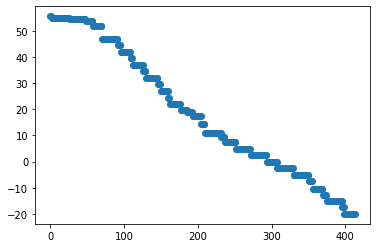

In [12]:
plt.scatter(
    np.arange(len(ompa_problem.obs_df)),
    ompa_problem.obs_df["latitude"])
plt.show()

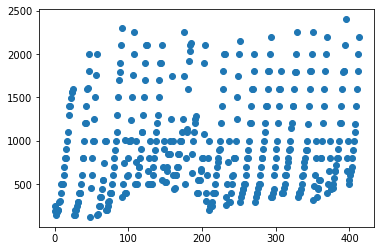

In [13]:
plt.scatter(
    np.arange(len(ompa_problem.obs_df)),
    ompa_problem.obs_df["depth"])
plt.show()